<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/%5BKI-Lab2021%5D%20Assignment%201%20OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment:
Preparation:
1. Checkout the notebook 0_Simple_NN.ipynb from Git, which describes how to
setup a simple feedforward network on some fake data. Try to understand
everything and execute the notebook. Ask on the chat if sth. is unclear.
2. Read through this blog post: https://nextjournal.com/gkoehler/pytorch-mnist
It shows how to work with data loaders, how to load the MNIST dataset and how
training is done in batches (using data loaders). 

Task:
1. Load the MNIST dataset into train and test data loaders. Use the same
parameters and apply the same transformations like described in the blog post.
2. Create a feedforward neural network consisting of an input layer, one hidden
layer of size 100 and an output layer (same structure as in Simple_NN.ipynb).
For training on the MNIST dataset you need to change the following:
  - Adjust the size of the input layer to be able to take in the MNIST data (hint: you
must adjust the tensor format from the MNIST data into a flat structure).
  - Use log_softmax as activation function for the output layer (as in the blog).
Note: Do not use a CNN like they do in the blog post! Use Relu as activation
function for the hidden layer.
3. Train your network on the training data for 50 epochs using the negative log
likelihood loss (like in the blog). Create a plot of the training loss (like in the blog
but without the test loss).
4. Test the network on the MNIST test data and give out accuracy and loss.
5. Find out how the model can be trained on the GPU instead of the CPU. Compare the
training time between CPU and GPU. (Note: Do not except too much improvement on
this small data set).
6. Repeat step 1. to 4. and see what happens when you try out:
  1. Two different hidden layer sizes.
  2. Using a normal softmax as activation function together with a CrossEntropyLoss.

In [94]:
#Import Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


# Parameter

In [95]:
n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 #0.1 
momentum = 0.5
log_interval = 10

random_seed = 1
GPU_ON = True
torch.backends.cudnn.enabled = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
print(device)

GPU_time = 0
CPU_time = 0
network = None
optimizer = None


cuda:0


# Download MNIST Dataset

In [96]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Explore Dataset

In [97]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [98]:
example_data.shape

torch.Size([1000, 1, 28, 28])

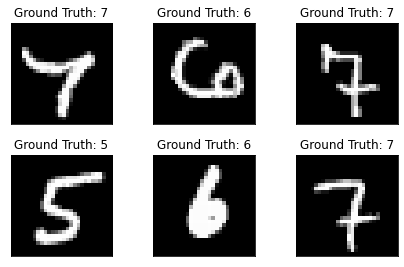

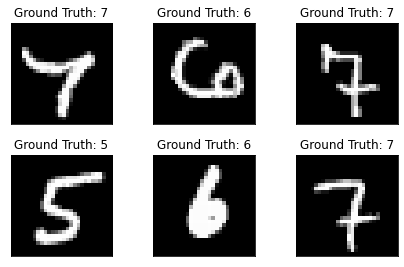

In [99]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Create Neural Network

In [100]:
class Net(nn.Module):
    def __init__(self, hidden_size, use_relu):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(28*28*1, hidden_size)
        self.output = torch.nn.Linear(hidden_size, 10)
        self.use_relu = use_relu

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = x.flatten(start_dim = 1)
        
        if self.use_relu:
          x = self.hidden(x).clamp(min=0)
        else:
          x = F.softmax(self.hidden(x))

        x = F.log_softmax(self.output(x))
        return x

# Training

In [101]:
def defineNetwork(hidden_size, use_relu):
  global network
  network = Net(hidden_size, use_relu)
  if GPU_ON:
    network.cuda()
    
  global optimizer
  optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [102]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      if GPU_ON:
        data = data.cuda()
        target = target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [103]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    if GPU_ON:
      data = data.cuda()
      target = target.cuda()
    output = network(data)
    loss = F.nll_loss(output, target)
    #F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [104]:

#CPU:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = False
defineNetwork(100, True)

CPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

CPU_time = time.time() - CPU_time

#GPU
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

GPU_time = time.time() - GPU_time

print("--- CPU: %s seconds ---" % (CPU_time))
print("--- GPU: %s seconds ---" % (GPU_time))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3206, Accuracy: 1176/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.384040
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.051963
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.782948
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.337704
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.229805
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.091962
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.099196
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.857733
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.689224
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.700881
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.610868
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.715553
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.632935
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.448870
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.397943
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.508472
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.484946
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.349393
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.472946
Train Epoch: 1 [12160

# Evaluation

Text(0, 0.5, 'negative log likelihood loss')

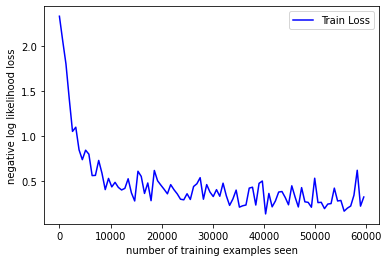

In [116]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')